In [ ]:
%%capture
!python3 -m pip install -U transformers
!python3 -m pip install -U datasets
!python3 -m pip install -U accelerate
!python3 -m pip install -U wandb

In [1]:
from transformers import pipeline
from tabulate import tabulate
import pandas as pd

label_map = {
    0: 'GENERAL POSITIVE',
    1: 'GENERAL NEGATIVE',
    2: 'PROFANITY',
    3: 'VIOLENCE'
}

# Sentiment Analysis
nepsa_model='/kaggle/input/nepsa-distilbert-model'
text_classifier = pipeline("text-classification", model=nepsa_model)

# Named Entity Recognition
nepner_model='/kaggle/input/nepner-roberta-model/nepsa_ner-roberta-epoch6'
token_classifier = pipeline(
    "token-classification", model=nepner_model, aggregation_strategy="simple"
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Perform Offensive Sentiment Classification

In [11]:
sentence = "भ्रश्ट्चारी हरुलाइ टुंडिखेल मा ल्याइ झुन्ड्याएर गोलि ठोक्नु पर्छ ।"

# The corrupt should be brought to Tundikhel and shot.

results = text_classifier(sentence)[0]
prediction_results = []
pred = results['label'].split('_')[1]

prediction_results.append([sentence, pred, label_map[int(pred)]])

print("Sentence:", sentence)
pd.DataFrame(prediction_results, columns=['Sentences', 'Predicted Label', 'Remarks'])

Sentence: भ्रश्ट्चारी हरुलाइ टुंडिखेल मा ल्याइ झुन्ड्याएर गोलि ठोक्नु पर्छ ।


,Sentences,Predicted Label,Remarks
0,भ्रश्ट्चारी हरुलाइ टुंडिखेल मा ल्याइ झुन्ड्याए...,3,VIOLENCE


## Perform Offensive Entity Recognition 

In [13]:
results = token_classifier(sentence)

ner_results = []
for each_entity in results:
    ner_results.append([each_entity['word'], each_entity['entity_group']])

print("Sentence:", sentence)
print("English translation: The corrupt should be brought to Tundikhel and shot.")
pd.DataFrame(ner_results, columns=['Word', 'Predictions'])

Sentence: भ्रश्ट्चारी हरुलाइ टुंडिखेल मा ल्याइ झुन्ड्याएर गोलि ठोक्नु पर्छ ।
English translation: The corrupt should be brought to Tundikhel and shot.


,Word,Predictions
0,भ्रश्ट्चारी,GENERAL
1,टु,LOC
2,ंडिखेल,ORG
3,गोलि ठोक्नु पर्छ,VIOLENCE


Our model performs pretty good.

## Perform testing on curated out of domain test set

In [4]:
!wget https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/out-of-domain/dataset.txt

--2023-12-06 02:49:31--  https://raw.githubusercontent.com/merishnaSuwal/nep-off-langdetect/main/NepSA/dataset/out-of-domain/dataset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6950 (6.8K) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>]   6.79K  --.-KB/s    in 0s      

2023-12-06 02:49:31 (64.6 MB/s) - ‘dataset.txt’ saved [6950/6950]



## Out-of-domain inference and testing

In [5]:
import pandas as pd

data = pd.read_csv('/kaggle/working/dataset.txt', delimiter='\t', names=['text', 'label'])
data.head()

,text,label
0,म लाई त यो मावबादी मनै पर्दैन तर गगन ले गरे को...,0
1,सुशील पान्दे is awesome ✌✌ ।,0
2,"प्रदिप यादव को कुरा एकदमै सहि छ , , ।",0
3,जुन दिन साझा पार्टी खराब निस्कन्छ अनि औला ठडाउ...,1
4,रातो लागाउनी सर को कुरो राम्रो लाग्यो ।,0


In [6]:
data['label'].value_counts()

label
1    14
0    13
2     6
3     3
Name: count, dtype: int64

In [7]:
sentences = list(data['text'].values)

prediction_results = []
for sentence in sentences:
    results = text_classifier(sentence)[0]
    pred = results['label'].split('_')[1]

    prediction_results.append([sentence, pred, label_map[int(pred)]])

pred_df = pd.DataFrame(prediction_results, columns=['Sentences', 'Predicted Label', 'Remarks'])
pred_df['Predicted Label'] = pred_df['Predicted Label'].astype(int)
pred_df['True_label'] = data['label'].values

In [8]:
pred_df.head()

,Sentences,Predicted Label,Remarks,True_label
0,म लाई त यो मावबादी मनै पर्दैन तर गगन ले गरे को...,0,GENERAL POSITIVE,0
1,सुशील पान्दे is awesome ✌✌ ।,0,GENERAL POSITIVE,0
2,"प्रदिप यादव को कुरा एकदमै सहि छ , , ।",0,GENERAL POSITIVE,0
3,जुन दिन साझा पार्टी खराब निस्कन्छ अनि औला ठडाउ...,0,GENERAL POSITIVE,1
4,रातो लागाउनी सर को कुरो राम्रो लाग्यो ।,0,GENERAL POSITIVE,0
5,धमला अरु को ( बोलाए को गेस्ट को ) कुरा सुन्न न...,1,GENERAL NEGATIVE,1
6,यो मुजि केपि को चम्चा लाइ नि गोलि खाना मन लायो...,2,PROFANITY,2
7,थुक्क पोखरेल भन्ने माहाभ्रष्ट को कुतर्क ।,1,GENERAL NEGATIVE,1
8,आफ्नो गरिमामय पद को पनि ख्याल नगरी बोल्ने व्यत...,1,GENERAL NEGATIVE,1
9,यो सति ले सरापे को देश मा भलो हुन्न ।,1,GENERAL NEGATIVE,1


## Clasification report and analysis

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming predictions and true_labels are your model's predictions and true labels
predictions = pred_df['Predicted Label'].values  # Replace with your actual prediction logic
true_labels = pred_df['True_label'].values  # Replace with your true labels

# Classification Report
class_report = classification_report(true_labels, predictions)
print("Classification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Individual misclassified instances
misclassified_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]
print("Misclassified Instances:")
for idx in misclassified_indices:
    print(f"Actual: {true_labels[idx]}, Predicted: {predictions[idx]}")


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.73      0.79      0.76        14
           2       0.62      0.83      0.71         6
           3       0.33      0.33      0.33         3

    accuracy                           0.72        36
   macro avg       0.65      0.66      0.65        36
weighted avg       0.74      0.72      0.72        36

Confusion Matrix:
[[ 9  4  0  0]
 [ 1 11  1  1]
 [ 0  0  5  1]
 [ 0  0  2  1]]
Misclassified Instances:
Actual: 1, Predicted: 0
Actual: 0, Predicted: 1
Actual: 1, Predicted: 2
Actual: 3, Predicted: 2
Actual: 1, Predicted: 3
Actual: 0, Predicted: 1
Actual: 0, Predicted: 1
Actual: 0, Predicted: 1
Actual: 2, Predicted: 3
Actual: 3, Predicted: 2


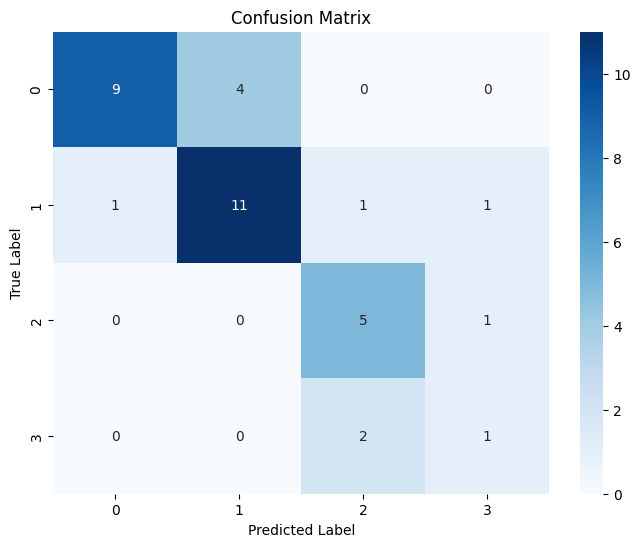

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2", "3"], yticklabels=["0", "1", "2", "3"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Extra text for inference

सुशील जि धन्यवाद जन्ता को आवाज बि ले को मा ।

Thank you Sushil ji for being the voice of the people.

---

येस्ता मानब अधिकार कर्मि को काम छइन ... ।

This human rights activist is of no use.

---

यो खाते अधिवक्ता दिनेश त्रिपाठी को अावज सुन्न पनि मन पर्दैन ।

I don't even like to hear the voice of this account advocate Dinesh Tripathi.

---

भ्रश्ट्चारी हरुलाइ टुंडिखेल मा ल्याइ झुन्ड्याएर गोलि ठोक्नु पर्छ ।

The corrupt should be brought to Tundikhel and shot.
